<a href="https://colab.research.google.com/github/Manuela-AYO/FraudDetection/blob/main/fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Online Payment Fraud Detection

## Libraries importation

In [80]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

In [81]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Exploration of Data

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/FraudDetection/Data/fraudDataset.csv")

In [ ]:
# shape
df.shape

(6362620, 11)

In [ ]:
# description
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00



1. step: represents a unit of time where 1 step equals 1 hour

2. type: type of online transaction

3. amount: the amount of the transaction

4. nameOrig: customer starting the transaction

5. oldbalanceOrg: balance before the transaction

6. newbalanceOrig: balance after the transaction

7. nameDest: recipient of the transaction

8. oldbalanceDest: initial balance of recipient before the transaction

9. newbalanceDest: the new balance of recipient after the transaction

10. isFraud: This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control of customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

11. isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.


In [ ]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [ ]:
df["type"].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

type is a categorical variable. And we have 5 types of transactions

In [ ]:
df.nameDest.head()

0    M1979787155
1    M2044282225
2     C553264065
3      C38997010
4    M1230701703
Name: nameDest, dtype: object

In [ ]:
df.isFraud.unique()

array([0, 1])

isFraud has value 0 if the transaction is not a fraud and 1 else

We won't use the column isFlaggedFraud because our goal there is  to classify the transactions as fraud or not. 

However, we will just check if the condition of a transaction being greater than 200000 is enough to flag it as fraud.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
# number of missing values on each column
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

There is no missing value

In [ ]:
# check the balance of each class
x, y= df["isFraud"].value_counts()
print(y, x)
print(y/x)

8213 6354407
0.0012924888191769902


Imbalancy between fraud and non-fraud transactions

In [ ]:
!pip install --upgrade pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# correlation
df.corr(numeric_only=True)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.003277
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.012295
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.003835
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.003776
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,-0.000513
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,-0.000529
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.044109
isFlaggedFraud,0.003277,0.012295,0.003835,0.003776,-0.000513,-0.000529,0.044109,1.000000


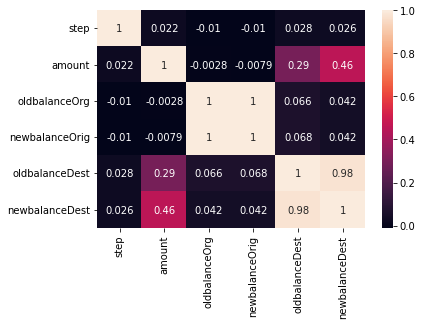

In [ ]:
temp = df.drop(columns=["isFraud", "isFlaggedFraud", "nameOrig",
                             "nameDest"])
temp.head()

sns.heatmap(temp.corr(numeric_only=True), annot=True)
plt.show()

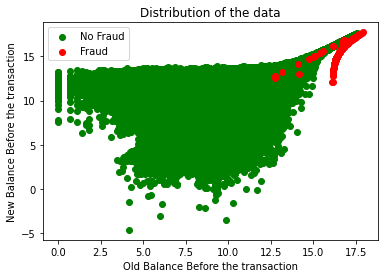

In [107]:
# visualization
plt.scatter(df[df["isFraud"] == 0]["oldbalanceOrg"].apply(np.log), df[df["isFraud"] == 0]["newbalanceOrig"].apply(np.log), 
            c="g", label="No Fraud")
plt.scatter(df[df["isFraud"] == 1]["oldbalanceOrg"].apply(np.log), df[df["isFraud"] == 1]["newbalanceOrig"].apply(np.log), 
            c="r", label="Fraud")
plt.xlabel("Old Balance Before the transaction")
plt.ylabel("New Balance Before the transaction")
plt.title("Distribution of the data")
plt.legend()
plt.show()

Just looking at the plot, it seems like there is an old balance threshold for which the transaction are most fraudulous

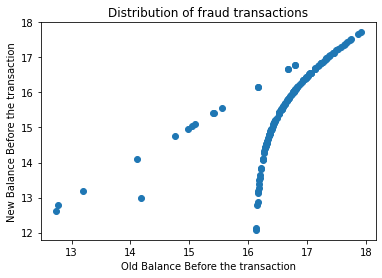

In [103]:
# fraud visualisation
plt.scatter(df[df["isFraud"] == 1]["oldbalanceOrg"].apply(np.log), df[df["isFraud"] == 1]["newbalanceOrig"].apply(np.log))
plt.xlabel("Old Balance Before the transaction")
plt.ylabel("New Balance Before the transaction")
plt.title("Distribution of fraud transactions")
plt.show()

## Preprocessing

In [ ]:
# remove the column isFlaggedFraud
df_flag = df["isFlaggedFraud"]
df = df.drop("isFlaggedFraud", axis=1)

In [ ]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud'],
      dtype='object')

In [ ]:
# change type to category
df.type = df.type.astype("category")

In [ ]:
# check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 10 columns):
 #   Column          Dtype   
---  ------          -----   
 0   step            int64   
 1   type            category
 2   amount          float64 
 3   nameOrig        object  
 4   oldbalanceOrg   float64 
 5   newbalanceOrig  float64 
 6   nameDest        object  
 7   oldbalanceDest  float64 
 8   newbalanceDest  float64 
 9   isFraud         int64   
dtypes: category(1), float64(5), int64(2), object(2)
memory usage: 443.0+ MB


In [ ]:
# split between target and predictors
X = df.drop(columns=["isFraud", "nameOrig", "nameDest"])
y = df.isFraud

In [ ]:
X.shape

(6362620, 7)

In [ ]:
l1 = y[y==0].index.tolist()
l2 = y[y==1].index.tolist()
print(f"len l1 : {len(l1)} len l2 : {len(l2)}")

len l1 : 6354407 len l2 : 8213


We'll take 100 data labeled with 1 and 1500 data labeled 0 due to memory cost of decision trees building.

In [ ]:
size_0 = 1500
size_1 = 100

In [ ]:
l1 = np.random.choice(l1, size_0, replace=False)
l2 = np.random.choice(l2, size_1, replace=False)

In [ ]:
X = pd.concat([X.iloc[l1], X.iloc[l2]])
y = pd.concat([y[l1], y[l2]])

print(X.shape, y.shape)

(1600, 7) (1600,)


In [ ]:
# split between train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(1120, 7)
(480, 7)


In [ ]:
print(y_train.value_counts())

0    1039
1      81
Name: isFraud, dtype: int64


## Models

On this section, we will use 2 classification algorithms : **Decision Trees ** and ** Random Forests **. 

### Classification

#### Decision Tree

Decision Tree is the white-box algorithm in machine learning. The aim is then to check the conditions corresponding to frauds

In [ ]:
# one-hot-encoding on type of transaction
X_train_conv = pd.get_dummies(X_train, columns=["type"])
X_train_conv.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
1030551,72,730574.39,730574.39,0.00,0.00,0.00,0,0,0,0,1
6196334,573,457789.14,457789.14,0.00,0.00,0.00,0,0,0,0,1
6149692,546,548731.73,0.00,0.00,1758607.46,2307339.19,0,0,0,0,1
5938711,404,2727.98,9940.00,7212.02,0.00,0.00,0,0,0,1,0
6361429,718,8925.61,36245.00,27319.39,0.00,0.00,0,0,0,1,0


In [ ]:
# first tree
clf = DecisionTreeClassifier(random_state=1)

In [ ]:
clf.fit(X_train_conv, y_train)

DecisionTreeClassifier(random_state=1)

In [ ]:
X_test_conv = pd.get_dummies(X_test, columns=["type"])

In [ ]:
# score
print(f"Accuracy : {clf.score(X_test_conv, y_test)}")

y_pred = clf.predict(X_test_conv)

print(f"F1-score(macro) : {f1_score(y_test, y_pred, average='macro')}")
print(f"F1-score(micro) : {f1_score(y_test, y_pred, average='micro')}")
f_scores = f1_score(y_test, y_pred, average=None)
for i in range(len(f_scores)):
    print(f"Score on class {i} : {f_scores[i]}")

Accuracy : 0.9854166666666667
F1-score(macro) : 0.9016134227401833
F1-score(micro) : 0.9854166666666667
Score on class 0 : 0.9924160346695557
Score on class 1 : 0.8108108108108109


Not bad. And it predicts better the majority class

In [ ]:
import pydotplus
from sklearn.tree import export_graphviz
from IPython.display import Image

def print_tree(classifier, attr):
    dot_data = export_graphviz(classifier,
                            feature_names=attr,
                            out_file=None,
                            filled=True,
                            rounded=True)
    return pydotplus.graph_from_dot_data(dot_data)

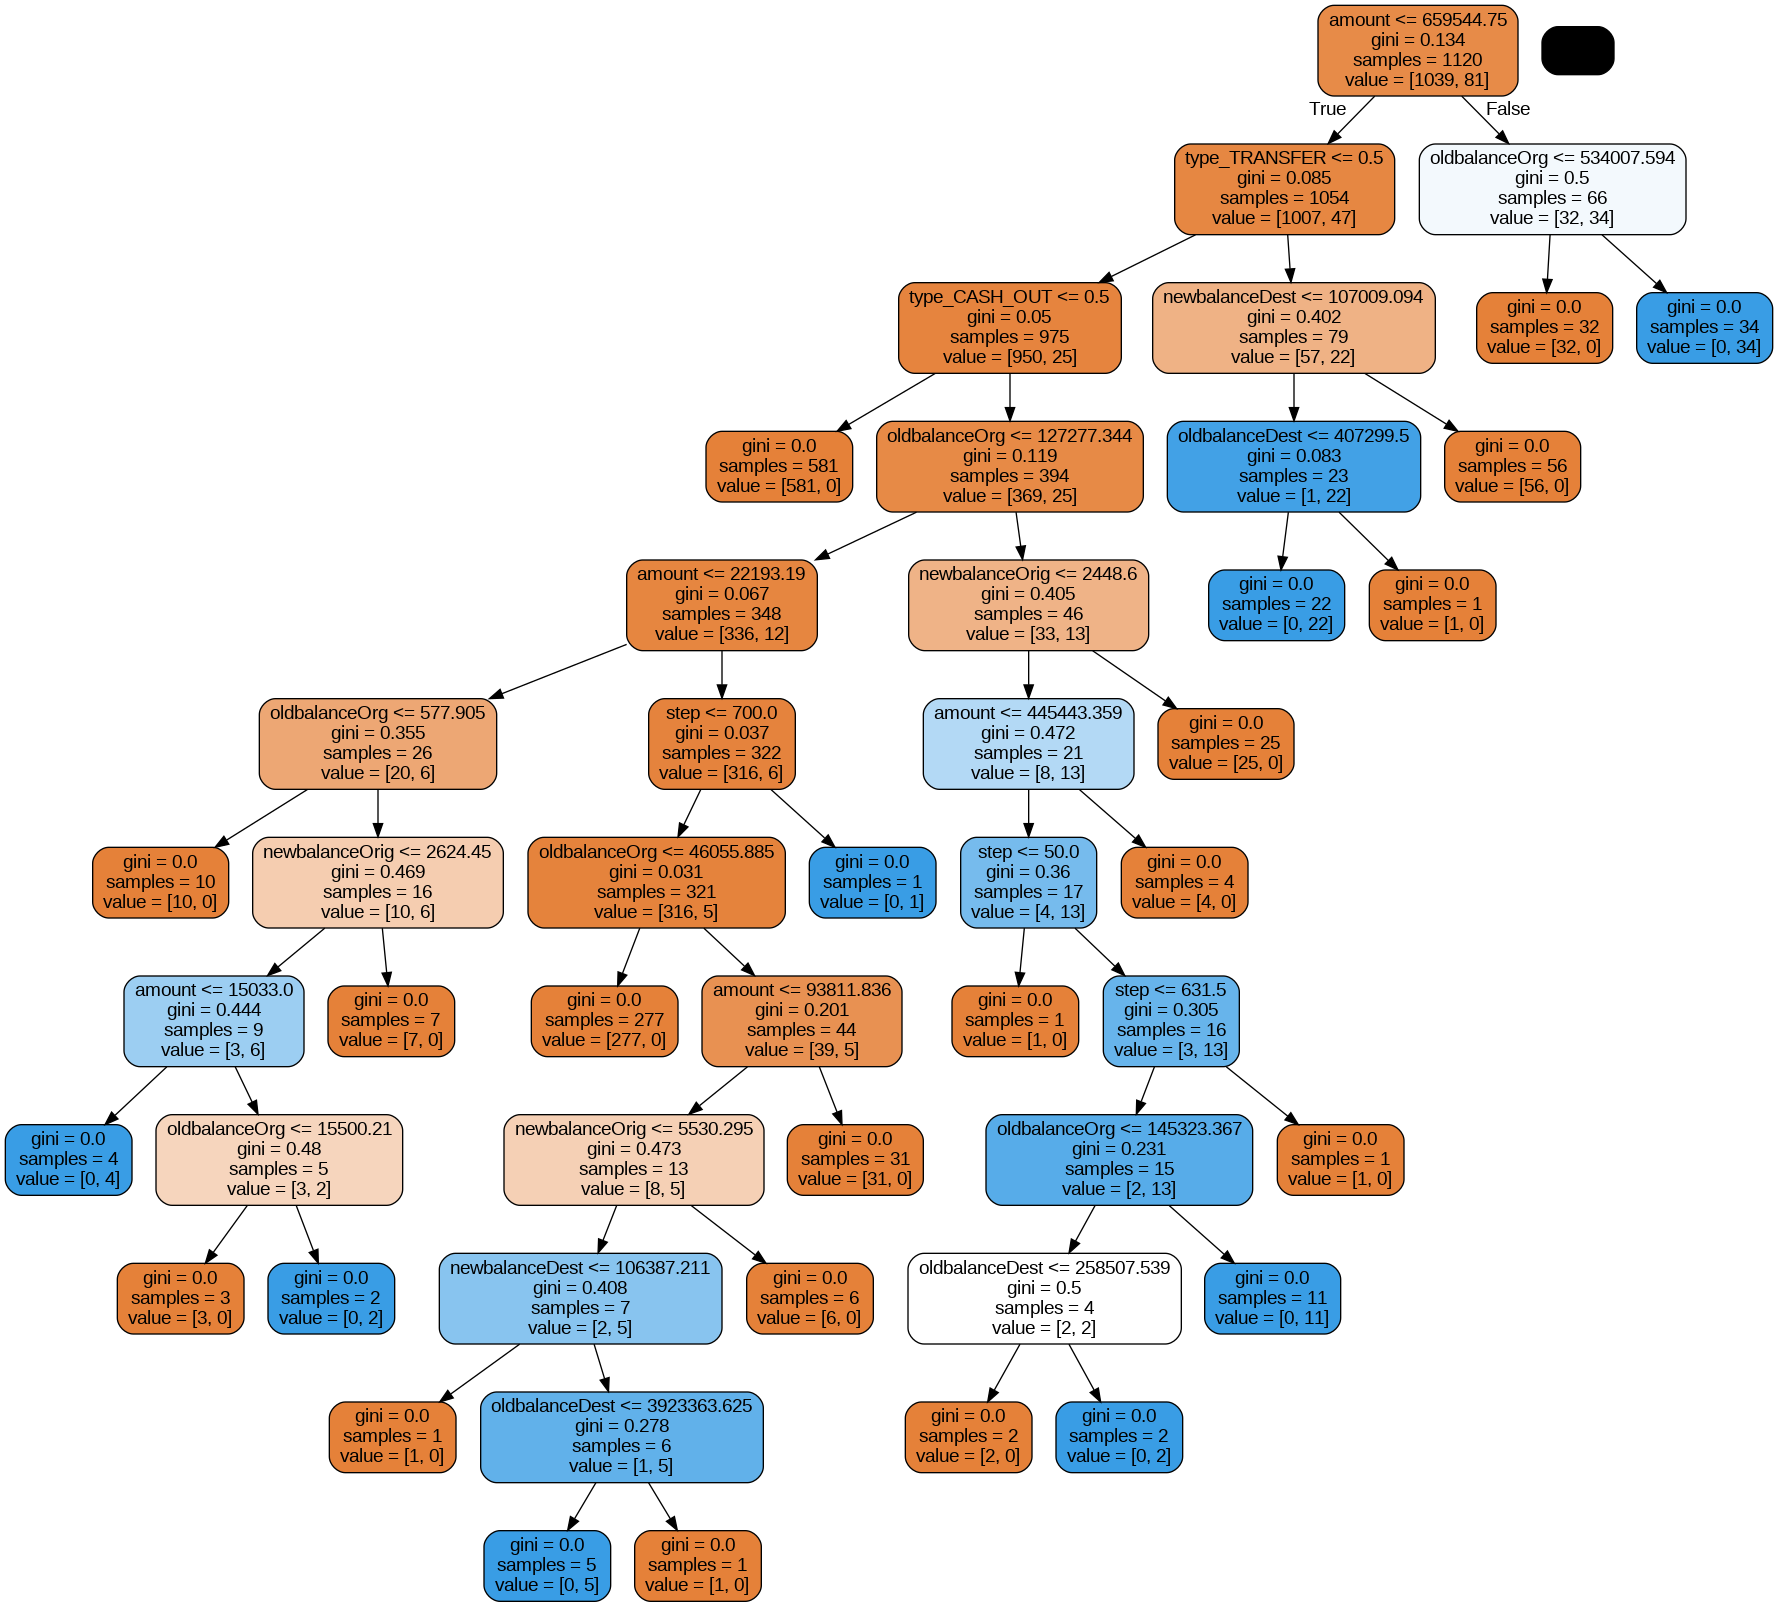

In [ ]:
names = X_test_conv.columns.tolist()
image = print_tree(clf, names)
Image(image.create_png())

From this first tree, we see that if the amount of transaction is greater than 659544.75 and the old balance of the account on which we want to make the transaction is greater than 534007.594, then the transaction is classified as fraud. 

At first sight, we may think that it's the other way around because what this tree is telling us is that if we take more than what we have in the bank account, that's not a big deal. 

Let us prune the tree and look at what will happen.

In [ ]:
# let us determine the different values of alpha of the tree
path = clf.cost_complexity_pruning_path(X_train_conv, y_train)

# extraction of those values of alpha
alphas = path.ccp_alphas

# exclude the maximum value for alpha
alphas = alphas[1:]

In [ ]:
alphas.shape

(10,)

In [ ]:
# let us look at the parameters of an optimal decision tree
dico = {
    "criterion" : ["gini", "entropy"],
    "ccp_alpha" : alphas
}

# number of validation sets
cv = 10

clf = GridSearchCV(
    DecisionTreeClassifier(), 
    param_grid=dico,
    cv=cv
)

In [ ]:
clf.fit(X_train_conv, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.00127551, 0.00136555, 0.00170807, 0.00178571, 0.00199091,
       0.0022012 , 0.00338135, 0.00465499, 0.01748989, 0.02699803]),
                         'criterion': ['gini', 'entropy']})

In [ ]:
clf.best_params_

{'ccp_alpha': 0.0022011953207069883, 'criterion': 'gini'}

Our best parameters there are gini criterion and ccp_alpha. 

Let's build the optimal tree

In [ ]:
clf = DecisionTreeClassifier(criterion="gini", ccp_alpha=0.0022011953207069883)

In [ ]:
clf.fit(X_train_conv, y_train)

DecisionTreeClassifier(ccp_alpha=0.0022011953207069883)

In [ ]:
# score
print(f"Accuracy : {clf.score(X_test_conv, y_test)}")

y_pred = clf.predict(X_test_conv)

print(f"F1-score(macro) : {f1_score(y_test, y_pred, average='macro')}")
print(f"F1-score(micro) : {f1_score(y_test, y_pred, average='micro')}")
f_scores = f1_score(y_test, y_pred, average=None)
for i in range(len(f_scores)):
    print(f"Score on class {i} : {f_scores[i]}")

Accuracy : 0.9895833333333334
F1-score(macro) : 0.9297238733858453
F1-score(micro) : 0.9895833333333334
Score on class 0 : 0.9945828819068255
Score on class 1 : 0.8648648648648649


It's better than our previous tree

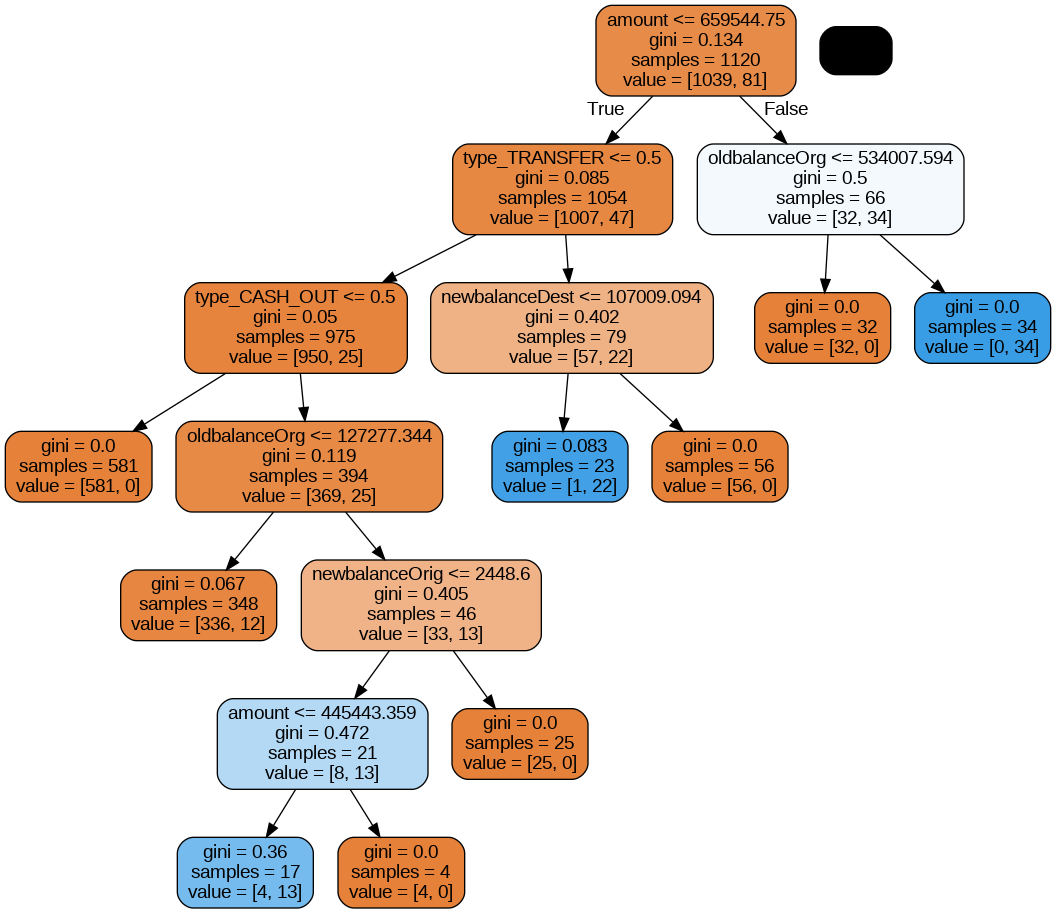

In [ ]:
image = print_tree(clf, names)
Image(image.create_png())

Let us interpret this tree

Is considered as fraud :    

1. A transaction from an account which previously had more than 534007.94 and wanted to made a transaction of more than 659544.75

2. The reception of an amount of money less or equal to 107009.094

3. A cashout of more than 120000

We also notice that the parameters take into account were mostly the amount of the transaction, the type of transaction, the old and new balance of the customer starting the transaction and the new balance of the account receiving the transaction.

Now let's check if those are really the most appropriate parameters using the decision tree

#### Random Forests

On the previous section, we built our classifier using the decision Tree. But we know that Random Forests are most stable than decision trees. So let's check the performance of random forests on these data

In [84]:
dico = {
    "n_estimators" : np.random.randint(50, 600, 10),
    "criterion" : ["entropy", "gini"] 
}

cv = 10

rf_clf = GridSearchCV(RandomForestClassifier(), dico, cv=cv)

rf_clf.fit(X_train_conv, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'n_estimators': array([127, 487,  87, 145, 585, 588, 135, 431, 195, 439])})

In [85]:
rf_clf.best_params_

{'criterion': 'entropy', 'n_estimators': 487}

In [86]:
# now let's build our optimal random forest
rf_clf = RandomForestClassifier(n_estimators=487, criterion="entropy")

# fit 
rf_clf.fit(X_train_conv, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=487)

In [87]:
# prediction
y_pred = rf_clf.predict(X_test_conv)

# accuracy
print(f"Accuracy : {rf_clf.score(X_test_conv, y_test)}")

# scores
print(f"Micro F1-score : {f1_score(y_test, y_pred, average='micro')}")
print(f"Macro F1-score : {f1_score(y_test, y_pred, average='macro')}")
# ****** scores on each label
f_scores = f1_score(y_test, y_pred, average=None)
for i in range(len(np.unique(y_test))):
    print(f"Score on class {i} : {f_scores[i]}")

Accuracy : 0.9895833333333334
Micro F1-score : 0.9895833333333334
Macro F1-score : 0.9258687258687259
Score on class 0 : 0.9945945945945946
Score on class 1 : 0.8571428571428572


98.95 seems to be the maximum accuracy that we can have.

But the prediction on the minority class is a bit lower than with decision trees.

Now, let's look at the most used parameters

In [88]:
# most used feature
list_feature_importances = rf_clf.feature_importances_.tolist()
list_feature_importances.index(rf_clf.feature_importances_.max()) 

2

The most used feature is the 3rd feature which is the oldbalanceOrg

In [89]:
columns = X_train_conv.columns.to_list()

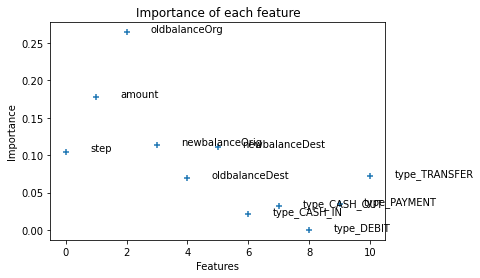

In [91]:
# plot of the features importance
plt.scatter(range(len(X_train_conv.columns)), list_feature_importances, marker="+")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Importance of each feature")
for i in range(len(columns)):
    plt.annotate(columns[i], (i, list_feature_importances[i]), xytext=(i+0.8, list_feature_importances[i]))
plt.show()

So the most used feature is the oldbalanceOrg followed by the amount and the newbalanceOrig.

That definetly makes sense as we can infer that you should make a certain transaction depending on what you have.

Now let us make a little throwback. 

At the begining, there was a column called isFlaggedFraud which just tagged as Fraud all the transactions with an amount of more than 200000.

But looking at the results of our models, it seems like just taking into consideration the amount is not relevant. 

It's like penalising an important business person by not allowing him to make some important transactions just due to our suspicious. 

The trees revealed us that not only the amount should be taken into consideration but also the original and the new balance of the customer who makes the transaction.